In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
prop_cal   = 0.25
prop_train = 0.50

N       = 2_000
N_cal   = int(N * prop_cal)
N_train = int(N * prop_train)

beta = np.random.random((2))
x = np.random.random((N, 2))
y = x @ beta

x_cal, y_cal     = x[:N_cal], y[:N_cal]
x_train, y_train = x[N_cal:N_cal+N_train], y[N_cal:N_cal+N_train]
x_test, y_test   = x[N_cal+N_train:], y[N_cal+N_train:]

In [3]:
reg_0 = LinearRegression().fit(x_train[:,0:1], y_train)
reg_1 = LinearRegression().fit(x_train[:,1:2], y_train)

In [4]:
cal_scores_0    = np.abs(reg_0.predict(x_cal[:,0:1]) - y_cal)
cal_scores_1    = np.abs(reg_1.predict(x_cal[:,1:2]) - y_cal)
cal_scores_full = np.vstack([cal_scores_0, cal_scores_1]).T

In [12]:
cal_dir_prop = .20 # reserve 20% to determine pre-ordering definition
cal_dir_N    = int(len(cal_scores_full) * cal_dir_prop)
cal_scores_dir, cal_scores_quant = cal_scores_full[:cal_dir_N], cal_scores_full[cal_dir_N:]

In [13]:
test_scores_0 = np.abs(reg_0.predict(x_test[:,0:1]) - y_test)
test_scores_1 = np.abs(reg_1.predict(x_test[:,1:2]) - y_test)
test_scores   = np.vstack([test_scores_0, test_scores_1]).T

In [14]:
alpha = 0.05
beta_int = [0, 2 * alpha]
coverage = -1
tolerance = 0.01

while np.abs(coverage - (1 - alpha)) > tolerance:
    beta = (beta_int[0] + beta_int[1]) / 2

    M = 10 # number of angle discretizations
    directions, quantiles, envelope_pts = [], [], []
    for m in range(M + 1):
        angle = (2 * np.pi / 4) * m / M
        direction   = np.array([np.cos(angle), np.sin(angle)])
        proj_scores = np.dot(cal_scores_dir, direction)

        sorted_quantile_idx = int((1 - beta) * len(proj_scores))
        sorted_scores = np.argsort(proj_scores)
        quantile_idx  = sorted_scores[sorted_quantile_idx]
        quantile      = np.quantile(proj_scores, q = 1 - beta)
        
        directions.append(direction)
        quantiles.append(proj_scores[quantile_idx])
        envelope_pts.append(cal_scores_dir[quantile_idx])
    directions, quantiles, envelope_pts = np.array(directions), np.array(quantiles), np.array(envelope_pts)

    proj_cal_scores_dir = np.array([np.dot(cal_scores_dir, direction) for direction in directions]).T
    coverage = np.sum(np.all(proj_cal_scores_dir < quantiles, axis=1)) / len(proj_cal_scores_dir)
    print(f"Contained: {coverage} -- {beta_int}")    
    if coverage > (1 - alpha):
        beta_int[0] = beta
    else:
        beta_int[1] = beta

Contained: 0.89 -- [0, 0.1]
Contained: 0.94 -- [0, 0.05]
Contained: 0.95 -- [0, 0.025]


In [18]:
proj_cal_scores_quant = (cal_scores_quant @ directions.T / quantiles)
ts        = np.max(proj_cal_scores_quant, axis=1)
t_hat     = np.quantile(ts, q = 1 - alpha)
quantiles *= t_hat
print(t_hat)

1.0


In [16]:
proj_test_scores = np.array([np.dot(test_scores, direction) for direction in directions]).T

In [17]:
contained = np.all(proj_test_scores < quantiles, axis=1)
percent_contained = np.sum(contained) / len(proj_test_scores)
print(f"Contained: {percent_contained}")

Contained: 0.96


In [11]:
import matplotlib.pyplot as plt
from matplotlib import colors

cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)

/tmp/ipykernel_10768/3782078199.py:9: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.cm.register_cmap(cmap=cmap)


ValueError: operands could not be broadcast together with shapes (250,) (11,) 

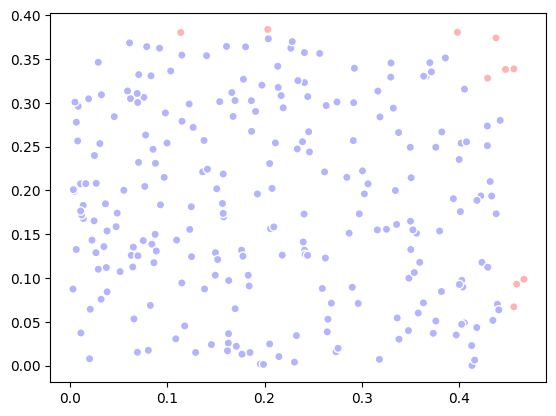

In [12]:
_, ax = plt.subplots(1, 1)

res = 100
dim = (0, 1)

contained = np.all(proj_test_scores < quantiles, axis=1)
ax.scatter(test_scores[:, dim[0]], test_scores[:, dim[1]], c=contained, cmap="red_blue_classes",
          linewidths=1., edgecolors="white")
xrange = ax.get_xlim()
yrange = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(*xrange, res),
                     np.linspace(*yrange, res))
xxf = xx.flatten()
yyf = yy.flatten()
xm = test_scores.mean(0)
XX = np.vstack([xm for _ in range(xxf.shape[0])])
XX[:, dim[0]] = xxf
XX[:, dim[1]] = yyf

proj_XX = np.array([np.dot(XX, direction) for direction in directions]).T
ZZ = np.all(proj_scores < quantiles, axis=1).astype(float)
zz = ZZ.reshape(xx.shape)
ax.pcolormesh(xx, yy, zz, cmap='red_blue_classes', shading="auto",
               norm=colors.Normalize(0., 1.), zorder=0)
ax.contour(xx, yy, zz, [0.5], linewidths=2., colors='white')

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

(0.0, 0.35)

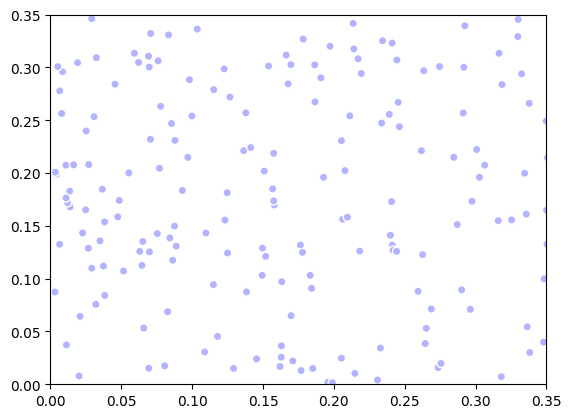

In [13]:
_, ax = plt.subplots(1, 1)
ax.scatter(test_scores[:,0], test_scores[:,1], c=contained, cmap="red_blue_classes", linewidths=1., edgecolors="white")

# for m in range(M + 1):
#     if abs(directions[m][1]) < 0.001: # special case of vertical line
#         ys = np.arange(0, 0.5, 0.01)
#         xs = np.ones(ys.shape) * envelope_pts[m][0]
#     else:
#         xs = np.arange(0, 0.5, 0.01)
#         ys = -(directions[m][0] / directions[m][1]) * (xs - envelope_pts[m][0]) + envelope_pts[m][1]
#     ax.plot(xs, ys, color="k")

ax.set_xlim(0, .35)
ax.set_ylim(0, .35)

# plt.scatter(test_scores[~contained][:,0],test_scores[~contained][:,1])
# plt.scatter(test_scores[contained][:,0], test_scores[contained][:,1])

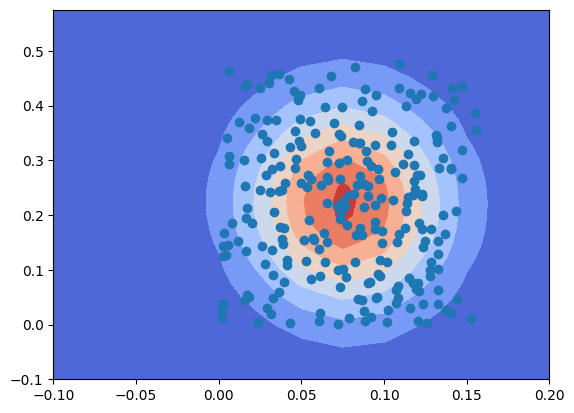

In [581]:
from scipy.stats import multivariate_normal

mean = np.mean(cal_scores, axis=0)
cov  = np.cov(cal_scores, rowvar=0)
prec = np.linalg.inv(cov)

x_min, x_max = np.min(cal_scores[:,0]), np.max(cal_scores[:,0])
y_min, y_max = np.min(cal_scores[:,1]), np.max(cal_scores[:,1])

x, y = np.mgrid[-0.1:0.2:0.025, -0.1:0.6:0.025]
rv = multivariate_normal(mean, cov)
data = np.dstack((x, y))
z = rv.pdf(data)
plt.contourf(x, y, z, cmap='coolwarm')
plt.scatter(cal_scores[:,0],cal_scores[:,1])

In [582]:
# 1 / rv.pdf(cal_scores)
mvcp_score_eval = lambda scores : (np.expand_dims(scores - mean, axis=1) @ prec @ np.expand_dims(scores - mean, axis=-1))
mvcp_scores   = mvcp_score_eval(cal_scores)
mvcp_quantile = np.quantile(mvcp_scores, q = 1 - alpha)

In [583]:
# test_mvcp_scores = 1 / rv.pdf(test_scores)
test_mvcp_scores = mvcp_score_eval(test_scores)
print(np.sum(test_mvcp_scores < mvcp_quantile) / len(test_scores))

0.948


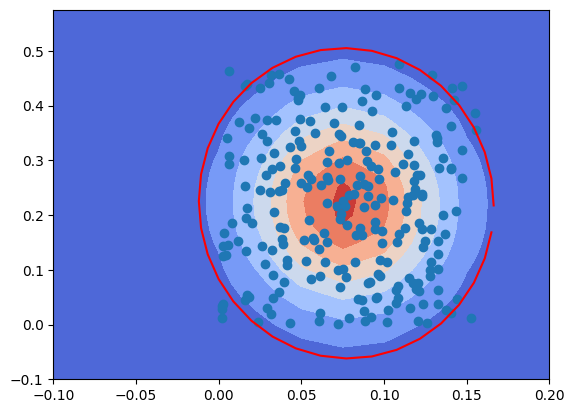

In [584]:
sqrt_cov = np.linalg.cholesky(cov)
eff_rad  = np.sqrt(mvcp_quantile)

theta        = np.arange(0, 2 * np.pi, 2 * np.pi / M)
zs           = np.array(list(zip(eff_rad * np.cos(theta), eff_rad * np.sin(theta))))
mvcp_contour = np.array([sqrt_cov @ z + mean for z in zs])

plt.contourf(x, y, z, cmap='coolwarm')
plt.plot(mvcp_contour[:,0], mvcp_contour[:,1], color="r") 
plt.scatter(cal_scores[:,0],cal_scores[:,1])

In [585]:
def norm_dir(pt):
    unnorm_dir = (pt - mean) @ (prec + prec.T)
    return unnorm_dir / np.linalg.norm(unnorm_dir)

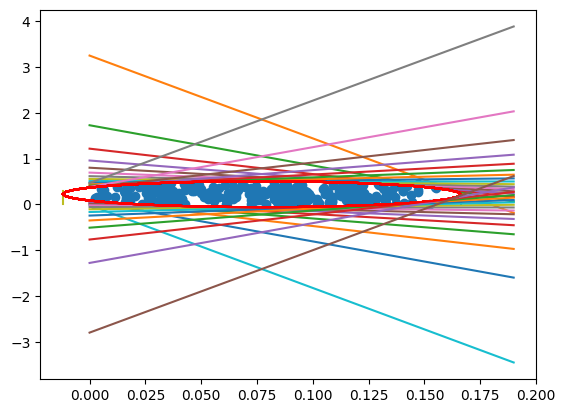

In [594]:
for m in range(M):
    dir_ = norm_dir(mvcp_contour[m])
    if abs(dir_[1]) < 0.001: # special case of vertical line
        line_ys = np.arange(0, 0.3, 0.01)
        line_xs = np.ones(line_ys.shape) * mvcp_contour[m][0]
    else:
        line_xs = np.arange(0, 0.2, 0.01)
        line_ys = -(dir_[0] / dir_[1]) * (xs - mvcp_contour[m][0]) + mvcp_contour[m][1]

    plt.plot(mvcp_contour[:,0], mvcp_contour[:,1], color="r") 
    plt.plot(line_xs, line_ys)
plt.scatter(cal_scores[:,0],cal_scores[:,1])

In [595]:
directions = np.array([norm_dir(mvcp_contour[m]) for m in range(M)])
mvcp_disc_quantiles = np.diag(mvcp_contour @ directions.T)

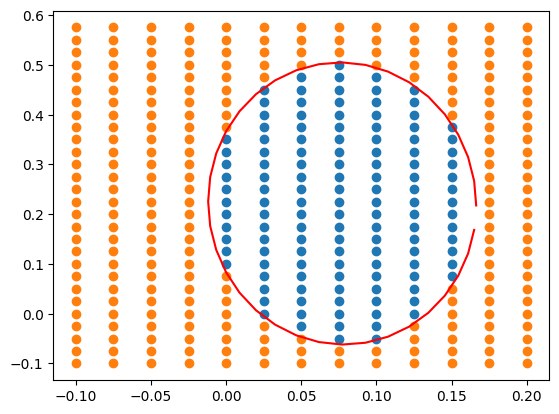

In [600]:
flat_viz_data = data.reshape(-1, 2)
viz_mvcp_scores = flat_viz_data @ directions.T
viz_covered = np.all(viz_mvcp_scores < mvcp_disc_quantiles, axis=1)

plt.plot(mvcp_contour[:,0], mvcp_contour[:,1], color="r") 
plt.scatter(flat_viz_data[viz_covered][:,0],flat_viz_data[viz_covered][:,1])
plt.scatter(flat_viz_data[~viz_covered][:,0],flat_viz_data[~viz_covered][:,1])